In [343]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import newton_krylov
import obspy
# from scipy.signal import find_peaks_cwt
%matplotlib inline

# Love Wave mode summation following Haskell (1951)
Model has $n$ layers, where the $n$th is the lower half-space and the zero-th is the free half-space. The layer boundaries $0$ to $n-1$ are above the $n$ layers.
## Theory
Displacement and stress within a homogeneous layer:
$$v = \exp[i(pt-kx)][v'\exp(-ikr_\beta z)+v''\exp(ikr_\beta z)]$$
$$Y_z = \mu\partial v/\partial z = ik\mu r_\beta \exp[i(pt-kx)][-v'\exp(-ikr_\beta z)+v''\exp(ikr_\beta z)]$$
Note that $p$ is the angular frequency, usually $\omega$.

Place the $z$ origin at the $(m-1)$th interface so that:
$$(\dot v/c)_{m-1} = ik(v_m'+v_m'')$$
$$(Y_z)_{m-1} = ik\mu_m r_{\beta m}(v_m''-v_m')$$

and at the $m$th interface (next one down, $z = d_m$):
$$(\dot v/c)_{m} = (v_m'+v_m'')ik\cos Q_m - (v_m''-v_m')\
sin Q_m$$
$$(Y_z)_{m} = -(v_m'-v_m'')k\mu_m r_{\beta m}\sin Q_m + (v_m''-v_m')k\mu_m r_{\beta m}\cos Q_m$$
where $Q = kr_{\beta m}d_m$

Eliminate the constants $v_m'$ and $v_m''$ to find:
$$(\dot v_m/c)_m = (\dot v/c)_{m-1}\cos Q_m + (Y_z)_{m-1}\mu_m^{-1}r_{\beta m}^{-1}i\sin Q_m$$
$$(Y_z)_m = (\dot v/c)_{m-1}i\mu_m r_{\beta m}\sin Q_m + (Y_z)_{m-1}\cos Q_m$$

So the propagator matrix (with a time derivative so that $l_1$ is replaced by $l_1 ik/c$) is:
$$a_m = \begin{bmatrix} \cos Q_m & i\mu_m^{-1}r_{\beta m}^{-1}\sin Q_m \\ i\mu_mr_{\beta m}\sin Q_m & \cos Q_m \end{bmatrix}$$

The combined propagation through all layers $A = a_{n-1}a_{n-2}...a_1$ leads to the equations at the lowest interface:
$$(\dot v/c)_{n-1} = A_{11}(\dot v/c)_0 + A_{12}(Y_z)_0$$
$$(Y_z)_{n-1} = A_{21}(\dot v/c)_0 + A_{22}(Y_z)_0$$

The coefficients in the lower half space are:
$$v_n'+v_n'' = A_{11}(ik)^{-1}(\dot v/c)_0 + A_{12}(ik)^{-1}(Y_z)_0$$
$$v_n''-v_n' = A_{21}(ik\mu_n r_{\beta n})^{-1}(\dot v/c)_0 + A_{22}(ik\mu_n r_{\beta n})^{-1}(Y_z)_0$$

The boundary conditions call for $(Y_z)_0 = 0$ and $v_n'' = 0$, so the dispersion relation is:
$$A_{21} = -\mu_n r_{\beta n}A_{11}$$

## Computation process
1. Find k(c) over the range of acceptable phase velocities (vs_min to vs_max)
2. Find $(\dot v/c)\cdot c/ik = l_1$ throughout the model at a range of frequencies
3. Plot $l_1$ and check boundary conditions and bounded-ness

In [721]:
# # Two layers over half-space (non-dimensionalized)
# dm = np.array([4, 21, 100])/4.0 #non-dimensional
# B = np.array([2.4, 3.5, 4.5])/2.4 #non-dimensional
# rho = np.array([2.0, 2.67, 3.3])/2.0 #non-dimensional
# mu = (B**2)*rho

# One layer over half-space (non-dimensionalized)
dm = np.array([40, 100])*100000 #cm
B = np.array([2.4, 3.5])*100000 #cm/s
rho = np.array([2.0, 2.67]) #g/cc
mu = (B**2)*rho 

# Bounds on phase velocity
cmin = min(B)
cmax = max(B)
c = np.linspace(cmin,cmax,100)

# Bounds on frequency
omega_max = 1.0
n_omega = 100
omega = np.linspace(.01,omega_max,n_omega)
# determine k_test values for given omega
omega_test = omega[1]
k_test = np.linspace(omega_test/c[-1],omega_test/c[0],1000) #decreasing

# r_b is a function of c and layer velocity
r_b = np.zeros((len(c),len(B)),dtype=complex)
for ci in range(len(c)):
    for bi in range(len(B)):
        if c[ci]>B[bi]:
            r_b[ci,bi] = np.sqrt((c[ci]/B[bi])**2-1)
        else:
            r_b[ci,bi] = -1j*np.sqrt(1-(c[ci]/B[bi])**2)
            
# Make A matrix as a function of k and c (index)
def A_mat(k,ci):
    # TODO solve case for ci=0 (currently sets a[0,1]=0)
    #calculate each a_m matrix and multiply
    A = np.ones((2,2),dtype=complex)
    a_m = np.zeros((2,2),dtype=complex)
    for m in [1]:
        Q_m = k*r_b[ci,m]*dm[m]
        if Q_m == np.real(Q_m):
            a_m[0,0] = np.cos(Q_m)
            a_m[1,1] = np.cos(Q_m)
            a_m[0,1] = 1j*np.sin(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sin(Q_m)
        else:
            a_m[0,0] = np.cosh(Q_m)
            a_m[1,1] = np.cosh(Q_m)
            a_m[0,1] = 1j*np.sinh(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sinh(Q_m)
        if ci == len(c)-1:
            a_m[0,1] = 0
        A = np.multiply(a_m,A)
    return A

# check dispersion relation
ci_test = -2
# k_test = np.array(range(50))+1
check_zero = np.zeros(len(k_test),dtype=complex)
for ki in range(len(k_test)):
    A = A_mat(k_test[ki],ci_test)
    check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
print A

[[ 0.99779972 +0.00000000e+00j -0.00000000 +2.54596669e-12j]
 [ 0.00000000 -1.72654124e+09j  0.99779972 +0.00000000e+00j]]


In [722]:
low_k_bound = 1.5e-6
low_k_ind = np.argwhere(k_test>low_k_bound)[0,0]
thresh = abs(check_zero[low_k_ind])
print thresh
hi_k_ind = low_k_ind+np.argwhere(abs(check_zero[low_k_ind:])>thresh)[0,0]
print hi_k_ind
get_k_ind = low_k_ind+np.argmin(abs(check_zero[low_k_ind:hi_k_ind]))
get_k = k_test[get_k_ind+10]
get_k

IndexError: index 0 is out of bounds for axis 0 with size 0

0

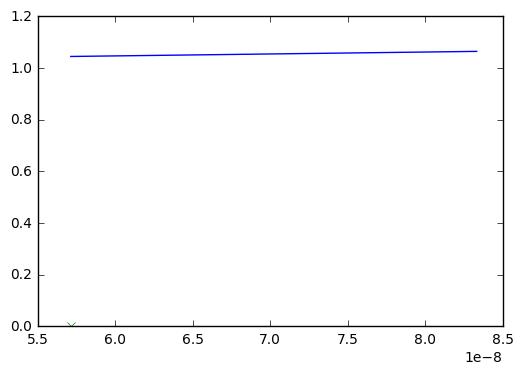

In [723]:
plt.plot(k_test,abs(check_zero))
plt.plot(k_test[get_k_ind],0,'x')
get_k_ind

In [543]:
k_of_c[66:] = 0

In [628]:
#save 4km layer results
k_of_c_4km = k_of_c

In [682]:
ci_list = np.array(range(len(c)-1)) #ci=0 works, last doesn't
k_of_c = np.zeros(ci_list.size)
low_k_bound = 1.5e-6
for ci in ci_list:
#     def check_dissipation(k):
#         A = A_mat(k,ci)
#         return abs(A[1,0]/(mu[-1]*r_b[ci,-1]) + A[0,0])
#     k_of_c[ci-1] = newton_krylov(check_dissipation,2e-6)
    for ki in range(len(k_test)):
        A = A_mat(k_test[ki],ci)
        check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
    # find zero of first mode, near 2.5e-6
    low_k_ind = np.argwhere(k_test>low_k_bound)[0,0]
    thresh = abs(check_zero[low_k_ind])
    hi_k_ind = low_k_ind+np.argwhere(abs(check_zero[low_k_ind:])>thresh)
    if not hi_k_ind.any():
        break
    else: hi_k_ind = hi_k_ind[0,0]
    get_k_ind = low_k_ind+np.argmin(abs(check_zero[low_k_ind:hi_k_ind]))
    k_of_c[ci] = k_test[get_k_ind]
    if thresh>1.2:
        low_k_bound += .1e-6

In [683]:
k_of_c

array([  2.91345801e-06,   2.92524491e-06,   2.93716276e-06,
         2.94934255e-06,   2.96178427e-06,   2.97435696e-06,
         2.98732254e-06,   3.00028812e-06,   3.01364660e-06,
         3.02726701e-06,   3.04101839e-06,   3.05516266e-06,
         3.06943790e-06,   3.08397506e-06,   2.85714286e-06,
         2.85714286e-06,   2.85714286e-06,   2.85714286e-06,
         2.85714286e-06,   2.85714286e-06,   2.85714286e-06,
         2.85714286e-06,   2.85714286e-06,   2.85714286e-06,
         2.85714286e-06,   2.85714286e-06,   2.85714286e-06,
         2.85714286e-06,   2.85714286e-06,   2.86238148e-06,
         2.87993085e-06,   2.89800409e-06,   2.91633925e-06,
         2.93532925e-06,   2.95458117e-06,   2.97435696e-06,
         2.99465661e-06,   3.01548012e-06,   3.03682749e-06,
         3.05869873e-06,   3.08122479e-06,   3.10427471e-06,
         3.12797946e-06,   3.15233904e-06,   3.17748442e-06,
         3.20328461e-06,   3.22973964e-06,   3.25711143e-06,
         3.28526900e-06,

In [644]:
b=np.argwhere(np.array([0,1])==2)
if not b.any():
    print 'empty'

empty


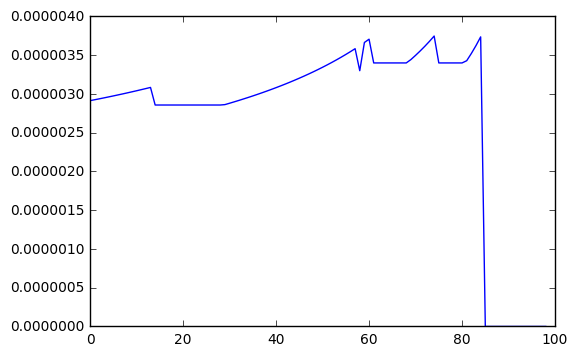

In [684]:
plt.plot(ci_list,k_of_c)

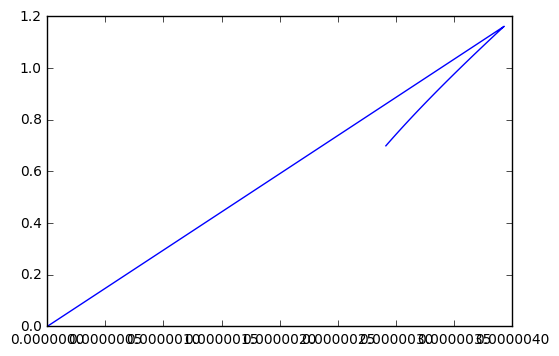

In [664]:
plt.plot(k_of_c,c[:-1]*k_of_c)

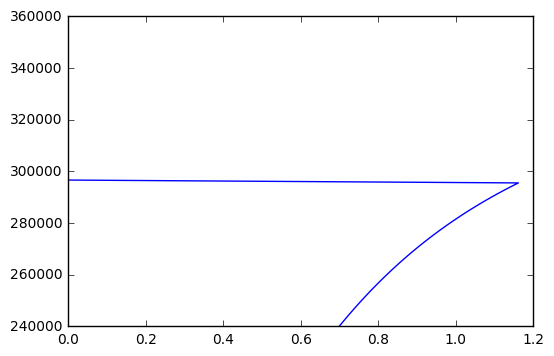

In [665]:
plt.plot(c[:-1]*k_of_c,c[:-1])

## non-dimensional version
I got confused trying to re-dimensionalize once solved. It's also out of date now

In [554]:
# # Two layers over half-space (non-dimensionalized)
# dm = np.array([4, 21, 100])/4.0 #non-dimensional
# B = np.array([2.4, 3.5, 4.5])/2.4 #non-dimensional
# rho = np.array([2.0, 2.67, 3.3])/2.0 #non-dimensional
# mu = (B**2)*rho

# One layer over half-space (non-dimensionalized)
dm = np.array([4, 100])/4.0 #non-dimensional
B = np.array([2.4, 4.5])/2.4 #non-dimensional
rho = np.array([2.0, 3.3])/2.0 #non-dimensional
mu = (B**2)*rho

# Bounds on phase velocity
cmin = min(B)
cmax = max(B)
c = np.linspace(cmin,cmax,1000)

# r_b is a function of c and layer velocity
r_b = np.zeros((len(c),len(B)),dtype=complex)
for ci in range(len(c)):
    for bi in range(len(B)):
        if c[ci]>B[bi]:
            r_b[ci,bi] = np.sqrt((c[ci]/B[bi])**2-1)
        else:
            r_b[ci,bi] = -1j*np.sqrt(1-(c[ci]/B[bi])**2)
            
# Make A matrix as a function of k and c (index)
def A_mat(k,ci):
    # TODO solve case for ci=0 (currently sets a[0,1]=0)
    #calculate each a_m matrix and multiply
    A = np.ones((2,2),dtype=complex)
    a_m = np.zeros((2,2),dtype=complex)
    for m in range(len(B)-1):
        Q_m = k*r_b[ci,m]*dm[m]
        if Q_m == np.real(Q_m):
            a_m[0,0] = np.cos(Q_m)
            a_m[1,1] = np.cos(Q_m)
            a_m[0,1] = 1j*np.sin(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sin(Q_m)
        else:
            a_m[0,0] = np.cosh(Q_m)
            a_m[1,1] = np.cosh(Q_m)
            a_m[0,1] = 1j*np.sinh(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sinh(Q_m)
        if ci == 0:
            a_m[0,1] = 0
        A = np.multiply(a_m,A)
    return A

# check dispersion relation
ci_test = 11
k_test = np.array(range(50))+1
check_zero = np.zeros(50,dtype=complex)
for k in k_test:
    A = A_mat(k,ci_test)
    check_zero[k-1] = A[1,0] + A[0,0]*mu[-1]*r_b[ci_test,-1]
print np.argwhere(abs(check_zero)<0.1)

[[10]]


## 2-layer analytic dispersion
$$\tan Q_1 = -i(\mu_2 r_{\beta 2}/\mu_1 r_{\beta 1})$$

/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


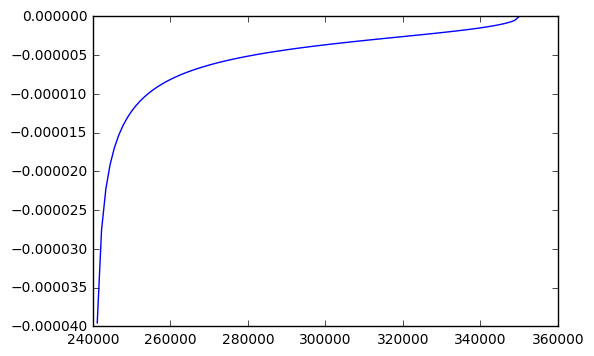

In [666]:
k_analytic = np.arctan(-1j*mu[1]*r_b[:,1]/(mu[0]*r_b[:,0]))/(r_b[:,0]*dm[0])
plt.plot(c,k_analytic)

/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


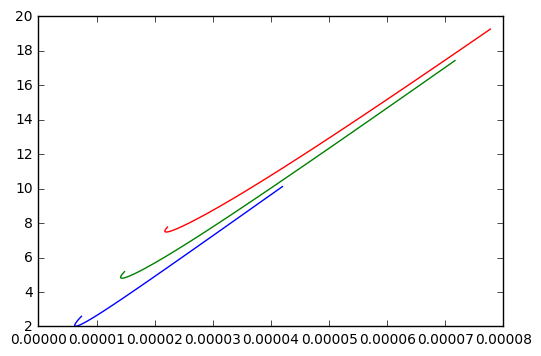

In [669]:
# plt.plot(k_analytic,c*k_analytic)
plt.plot(temp,c*temp)
plt.plot(temp2[3:],c[3:]*temp2[3:])
plt.plot(temp3[7:],c[7:]*temp3[7:])

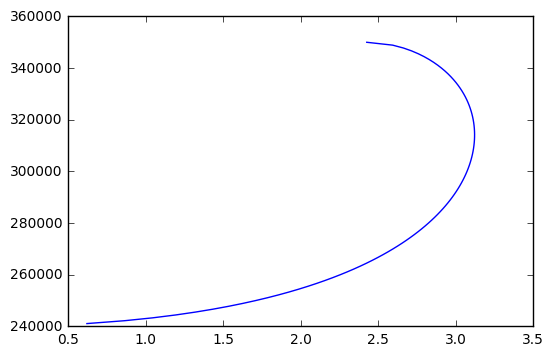

In [670]:
plt.plot((2*np.pi)/omega_funds,c)

In [667]:
temp =(np.arctan(np.real(-1j*mu[1]*r_b[:,1]/(mu[0]*r_b[:,0])))+np.pi)/(r_b[:,0]*dm[0])
temp2 =(np.arctan(np.real(-1j*mu[1]*r_b[:,1]/(mu[0]*r_b[:,0])))+2*np.pi)/(r_b[:,0]*dm[0])
temp3 =(np.arctan(np.real(-1j*mu[1]*r_b[:,1]/(mu[0]*r_b[:,0])))+3*np.pi)/(r_b[:,0]*dm[0])


/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [668]:
#frequency and wave number range for fundamental mode
omega_funds = c*temp
max((2*np.pi)/omega_funds[1:])

/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


(3.1219278943300721+0j)

In [581]:
b=np.arctan(1)
np.tan(b-2*np.pi)

1.0000000000000004